In [7]:
from __future__ import print_function
import torch

## Key parts of a NN: 

1. Vectorized inputs 
2. Network layers are represented by weights 
3. Loss function e.g. for contoinuous variables, use MSE, for multi-class classification use categorical cross entropy loss 
4. Optimizer to minimize this loss and update weights 


In [8]:
import torch 

In [9]:
import torch.nn as nn 

In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


## Turning names into tensors

In [11]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [13]:
import random

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Khoury
category = Russian / line = Baewsky
category = Portuguese / line = Belo
category = German / line = Konigsmann
category = Greek / line = Gavrilopoulos
category = Arabic / line = Boutros
category = Polish / line = Bobienski
category = Greek / line = Sakellariou
category = German / line = Tritten
category = Dutch / line = Roijackers


### Define RNN and train 

In [14]:
import torch.nn as nn 

In [18]:
class RNN(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden 
    
    def initHidden(self): 
        return torch.zeros(1, self.hidden_size)
    
    
n_hidden = 128 
rnn = RNN(n_letters, n_hidden, n_categories)
input = lineToTensor('albert')
hidden = rnn.initHidden()
output, next_hidden = rnn.forward(input[0], hidden)
print(categoryFromOutput(output))
# input side in n_letters because we are one-hot encoding all the letters 

('Italian', 12)


#### Training the NN 

In [19]:
criterion = nn.NLLLoss()

In [20]:
def train_rnn(category_tensor, line_tensor): 
    
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]): 
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameter gradients to their values 
    
    for p in rnn.parameters(): 
        p.data.add_(p.grad.data, alpha=-1*learning_rate)
        
    return output, loss.item()
        

In [21]:
learning_rate = 0.005

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_rnn(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.3598 Monahan / Irish ✓
10000 10% (0m 12s) 2.6780 Murphy / Arabic ✗ (Scottish)
15000 15% (0m 18s) 3.6982 Bakoff / Japanese ✗ (Russian)
20000 20% (0m 24s) 2.4903 Hildebrand / Italian ✗ (German)
25000 25% (0m 30s) 1.6231 Nisi / Japanese ✗ (Italian)
30000 30% (0m 36s) 2.0618 Andrew / Spanish ✗ (English)
35000 35% (0m 42s) 0.4472 Vourlis / Greek ✓
40000 40% (0m 49s) 1.1506 Gwang  / Korean ✓
45000 45% (0m 55s) 0.7924 Jamieson / Scottish ✓
50000 50% (1m 1s) 0.9075 Quraishi / Japanese ✗ (Arabic)
55000 55% (1m 7s) 0.1420 Asfour / Arabic ✓
60000 60% (1m 13s) 1.4180 Whelan / Irish ✓
65000 65% (1m 19s) 0.4923 Kato / Japanese ✓
70000 70% (1m 25s) 2.9417 Deschamps / German ✗ (French)
75000 75% (1m 31s) 1.5961 Kondo / Japanese ✓
80000 80% (1m 37s) 2.7847 Nutella / Spanish ✗ (English)
85000 85% (1m 43s) 0.8281 Herten / Dutch ✓
90000 90% (1m 49s) 1.5606 O'Bree / Portuguese ✗ (Irish)
95000 95% (1m 55s) 1.9223 Koukal / Japanese ✗ (Czech)
100000 100% (2m 1s) 1.2122 Jansen / English ✓


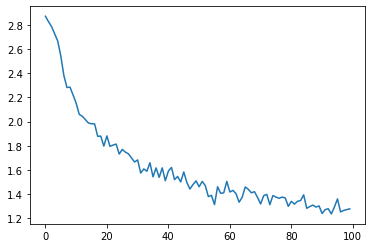

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-25-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-25-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


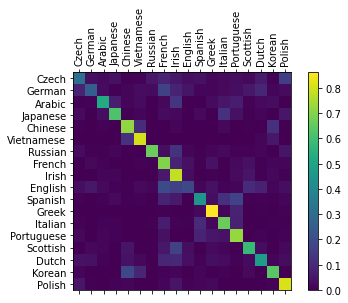

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.86) Russian
(-1.22) Czech
(-1.79) Polish

> Jackson
(-0.17) Scottish
(-2.36) English
(-4.29) Russian

> Satoshi
(-0.56) Polish
(-1.80) Italian
(-2.55) Japanese


In [27]:
predict('Gowardhan')


> Gowardhan
(-1.52) Irish
(-1.55) Scottish
(-1.57) English


## testing LSTMs

In [31]:
class lstm_test(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size 
        self.lstm_layer = nn.LSTM(input_size, hidden_size,  num_layers= 2, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)        
        
    def forward(self, input):
        output, (h_n, c_n) = self.lstm_layer(input)
        output = self.linear(output)
        return output.view(1, -1)
    
lstm_test = lstm_test(n_letters, n_hidden, n_categories)
# input side in n_letters because we are one-hot encoding all the letters 

In [32]:
def train_lstm(category_tensor, line_tensor): 
    
    lstm_test.zero_grad()
    
    for i in range(line_tensor.size()[0]): 
        output = lstm_test(line_tensor[i].view(1,1,-1))
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameter gradients to their values 
    
    for p in lstm_test.parameters(): 
        p.data.add_(p.grad.data, alpha=-1*learning_rate)
        
    return output, loss.item()
        

In [34]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) -22.6837 Kreskas / French ✗ (Greek)
10000 10% (0m 36s) -122.9071 St pierre / German ✗ (French)
15000 15% (0m 54s) -221.8017 Haruguchi / German ✗ (Japanese)
20000 20% (1m 12s) -326.9152 Giugovaz / Korean ✗ (Italian)
25000 25% (1m 30s) -460.3972 Leverenz / German ✓
30000 30% (1m 49s) -531.2944 Jamieson / Korean ✗ (Scottish)
35000 35% (2m 7s) -639.2178 Fiscella / Korean ✗ (Italian)
40000 40% (2m 25s) -726.7217 Kamachi / Korean ✗ (Japanese)
45000 45% (2m 43s) -883.4091 Danichenko / Korean ✗ (Russian)
50000 50% (3m 1s) -957.9390 Koziol / Korean ✗ (Polish)
55000 55% (3m 19s) -1101.5272 Kramer / Korean ✗ (German)
60000 60% (3m 38s) -1119.2952 Kollen / French ✗ (Dutch)
65000 65% (3m 56s) -1262.0627 Walton / Chinese ✗ (English)
70000 70% (4m 14s) -1389.0527 Alo / Chinese ✗ (Italian)
75000 75% (4m 32s) -1455.6912 Scott / Chinese ✗ (Scottish)
80000 80% (4m 50s) -1594.5300 Rutkowski / Chinese ✗ (Polish)
85000 85% (5m 8s) -1685.5916 Thuy / Chinese ✗ (Vietnamese)
90000 90% (5m 27s) 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):

    for i in range(line_tensor.size()[0]):
        output = lstm_test(line_tensor[i].view(1,1,-1))

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Exercises
Try with a different dataset of 
- line -> category, for example:
- Any word -> language
- First name -> gender
- Character name -> writer
- Page title -> blog or subreddit
- Get better results with a bigger and/or better shaped network
- Add more linear layers
- Try the nn.LSTM and nn.GRU layers
- Combine multiple of these RNNs as a higher level network
- Using this to classify spam vs no spam  - spam_df = pd.read_csv('./SPAM text message 20170820 - Data.csv')
